In [2]:
import tensorflow as tf
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.metrics import accuracy_score2
import nltk
#nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import mean
from sklearn import preprocessing

2022-04-23 19:31:14.746077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-23 19:31:14.746114: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#TRAIN DATA
path = '/home/spetz/Downloads/DeliciousMIL/Data/train-data.dat'


clean_files = []
df = pd.DataFrame()

file = open(path).readlines()
len(file)


clean_doc = []
wordfreq = {}
for doc in file:
    tokens = nltk.word_tokenize(doc)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [4]:
from nltk.probability import FreqDist
fdist = FreqDist()

sentence_vectors = []
for doc in file:
    doc_tokens = nltk.word_tokenize(doc)
    vec = []
    for token in wordfreq:
        if token in doc_tokens:
            count = 0
            for tok in doc_tokens:
                if tok == token:
                    count += 1
            vec.append(count)
        else:
            vec.append(0)
    sentence_vectors.append(vec)

In [5]:
#TEST-DATA
path = '/home/spetz/Downloads/DeliciousMIL/Data/test-data.dat'

clean_files = []
df = pd.DataFrame()

file = open(path).readlines()
len(file)

clean_docc = []
wordfreqq = {}
for doc in file:
    tokens = nltk.word_tokenize(doc)
    for token in tokens:
        if token not in wordfreqq.keys():
            wordfreqq[token] = 1
        else:
            wordfreqq[token] += 1


In [6]:
fdist = FreqDist()
sentence_vectorss = []
for doc in file:
    doc_tokens = nltk.word_tokenize(doc)
    vecc = []
    for token in wordfreqq:
        if token in doc_tokens:
            count = 0
            for tok in doc_tokens:
                if tok == token:
                    count += 1
            vecc.append(count)
        else:
            vecc.append(0)
    sentence_vectorss.append(vecc)


In [7]:
#same length lists
#X_train = pad_sequences(sentence_vectors , padding = 'post',maxlen=20,dtype='float32')
#X_test = pad_sequences(sentence_vectorss , padding = 'post',maxlen=20 ,dtype='float32')
#np
#train_data
x=sentence_vectors[:3983]
X_train =np.array(x)
#test data
X_test =np.array(sentence_vectorss)

#morfopoihsh 
X_train=X_train[:, :-320]
X_test=X_test[:, :-1]

#load labels
labels_fnames = [
            '/home/spetz/Downloads/DeliciousMIL/Data/train-label.dat',
            '/home/spetz/Downloads/DeliciousMIL/Data/test-label.dat'
            ]

Y_train = pd.read_csv(labels_fnames[0], nrows=3983 , delimiter = ' ', header = None)
Y_test= pd.read_csv(labels_fnames[1], delimiter = ' ', header = None)


#len(test_labels) 3983
#len(train_labels) 8251
#one- hot -encoding
#Y_train = tf.keras.utils.to_categorical(Y_train,20 )
#Y_test = tf.keras.utils.to_categorical(Y_test,20 )

def preprocessing(X_train,Y_train,X_test,Y_test,type="Normalization"):

            #NORMALIZATION#
    if type == "Normalization":
        X_train_normalized = tf.keras.utils.normalize(X_train)
        X_test_normalized = tf.keras.utils.normalize(X_test)
        return X_train_normalized,Y_train,X_test_normalized,Y_test

            #STANDARDIZED#
    elif type == "Standardized":
        scaler = StandardScaler()
        X_train_Standardized =scaler.fit_transform(X_train)
        X_test_Standardized=scaler.fit_transform(X_test)
        return X_train_Standardized,Y_train,X_test_Standardized,Y_test
            #NORM-WITH MINMAX#
    elif type == "MinMax":
        scaler = MinMaxScaler()
        X_train_minmax = scaler.fit_transform(X_train)
        X_test_minmax = scaler.fit_transform(X_test)
        return X_train_minmax , Y_train ,X_test_minmax ,Y_test

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(3983, 8202) (3983, 8202) (3983, 20) (3983, 20)


In [8]:
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v1 import SGD
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping



def create_model():
    model = Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(4003, activation='relu', input_shape=(3983,)))
    model.add(Dense(20, activation='softmax'))
    # optimizer = keras.optimizers.Adam(lr=0.01)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model 
def create_model_mse():
    model = Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(4003, activation='relu', input_shape=(3983,)))
    model.add(Dense(20, activation='softmax'))
    # optimizer = keras.optimizers.Adam(lr=0.01)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model 

def evaluate_model(X_train_normalized,Y_train,X_test_normalized,Y_test):            
    fold_number2=0
    fold_number = 0
    sum_of_acc2 =0
    sum_of_loss2 = 0
    sum_of_acc=0
    sum_of_loss=0
    losses,scores,histories = list(),list(),list()
    losses2,scores2,histories2 = list(),list(),list()
    kfold = KFold(n_splits=5, shuffle=False, random_state=None)
    epochs = 5
    for train_index, test_index in kfold.split(X_train_normalized,Y_train):  
        shallow_mlp_model = create_model()
        mse_model = create_model_mse()
        #es=EarlyStopping(monitor='val_loss' , mode='min' , verbose=1)
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_train_normalized[train_index,:], X_train_normalized[test_index,:]
        y_train, y_test = Y_train.iloc[train_index],Y_train.iloc[test_index]
    
        #callback =EarlyStopping(monitor='val_accuracy' , mode="max" , min_delta=0 , patience=5 , verbose=1)
        #MODEL for cross-entropy

        history = shallow_mlp_model.fit(X_train_normalized[train_index,:],Y_train.iloc[train_index] ,  epochs=epochs , validation_data=(X_test, y_test) , verbose=1)
        loss, val_acc = shallow_mlp_model.evaluate(X_test_normalized,Y_test,verbose=1)
        #MODEL 2 for Mse
       
        history2 = mse_model.fit(X_train_normalized[train_index,:],Y_train.iloc[train_index] ,  epochs=epochs , validation_data=(X_test, y_test) ,verbose=1)
        loss2, val_acc2 = mse_model.evaluate(X_test_normalized,Y_test,verbose=1)
    
    


        print("-"*80)
        ###########################
        fold_number +=1 
        fold_number2 +=1
        ##########################
        print(" for cross entropy fold",(fold_number),"\n|  loss:" , loss, "Accuracy:",val_acc)
        print(" for Mse fold",(fold_number2),"\n|  loss:" , loss2, "Accuracy:",val_acc2)
        ##########################
        sum_of_acc += val_acc
        sum_of_loss += loss
        #########################
        sum_of_loss2 +=loss2
        sum_of_acc2 += val_acc2

        scores.append(val_acc)
        histories.append(history)
        scores2.append(val_acc2)
        histories2.append(history2)

        print("-"*80)
        print("\n Cross-Entropy:the average of the loss and acc is: \n","loss:" , sum_of_loss/fold_number, "\n" , "Accuracy" , sum_of_acc/fold_number,"\n")
        print("\n MSE:the average of the lose and acc is: \n","loss:" , sum_of_loss2/fold_number2, "\n" , "Accuracy" , sum_of_acc2/fold_number2,"\n")
        
    return history,history2


    
def create_model_plots(history,history2):
        plt.figure(0)
        plt.subplot(2, 2, 1)
        plt.plot(history.history['accuracy'], label='Accuracy (train)')
        plt.plot(history.history['val_accuracy'], label='Accuracy (test)')
        plt.title("Accuracy with Cross Entropy loss")
        plt.ylabel("Accuracy")
        plt.xlabel("Epochs")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(history2.history['accuracy'], label='Accuracy (train)')
        plt.plot(history2.history['val_accuracy'], label='Accuracy (test)')
        plt.title("Accuracy with MSE loss")
        plt.ylabel("Accuracy")
        plt.xlabel("Epochs")
        plt.tight_layout()
        plt.show()

    # plot the cross entropy loss
        plt.figure(1)
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Cross entropy (train)')
        plt.plot(history.history['val_loss'], label='Cross entropy (test)')
        plt.title('Cross Entropy Evaluated')
        plt.xlabel('Epochs')
        plt.ylabel('Error value')
        plt.legend()

    # plot the mse loss
        plt.subplot(2, 2, 2)
        plt.plot(history2.history['loss'], label='MSE (train)')
        plt.plot(history2.history['val_loss'], label='MSE (test)')

        plt.title('MSE Evaluated')
        plt.xlabel('Epochs')
        plt.ylabel('Error value')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    




2022-04-23 19:34:32.044336: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-23 19:34:32.044405: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spetz-ZenBook-UX434IQ-Q407IQ): /proc/driver/nvidia/version does not exist
2022-04-23 19:34:32.045138: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
100/100 [==============================] - 7s 71ms/step - loss: 0.3866 - accuracy: 0.2746 - val_loss: 0.3261 - val_accuracy: 0.3413
Epoch 2/5
100/100 [==============================] - 7s 69ms/step - loss: 0.2164 - accuracy: 0.4200 - val_loss: 0.3245 - val_accuracy: 0.2936
Epoch 3/5
100/100 [==============================] - 7s 70ms/step - loss: 0.1229 - accuracy: 0.4212 - val_loss: 0.3650 - val_accuracy: 0.2836
Epoch 4/5
100/100 [==============================] - 7s 69ms/step - loss: 0.0746 - accuracy: 0.4344 - val_loss: 0.4175 - val_accuracy: 0.2811
Epoch 5/5
125/125 [==============================] - 2s 15ms/step - loss: 0.7475 - accuracy: 0.1188
Epoch 1/5
100/100 [==============================] - 7s 70ms/step - loss: 0.1219 - accuracy: 0.2875 - val_loss: 0.1181 - val_accuracy: 0.3300
Epoch 2/5
100/100 [==============================] - 7s 68ms/step - loss: 0.1049 - accuracy: 0.4281 - val_loss: 0.1168 - val_accuracy: 0.3137
Epoch 3/5
100/100 [=============================

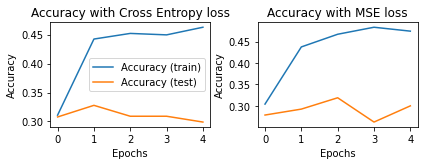

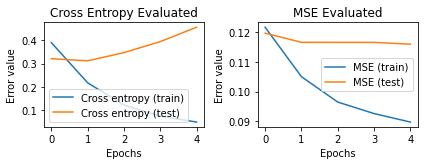

In [9]:
def run_test():
   x_train,y_train,x_test,y_test=preprocessing(X_train,Y_train,X_test,Y_test,type="MinMax")
   h1,h2 = evaluate_model(x_train,y_train,x_test,y_test)
   create_model_plots(h1,h2)
run_test()


